## Import libraries

In [261]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Import data

In [5]:
mean_interest = pd.read_csv("E:/Projects/real-estate-analysis/data/mean_interest_q.csv")
requests_vl = pd.read_csv("E:/Projects/real-estate-analysis/data/permits_reg.csv")
prices = pd.read_csv("E:/Projects/real-estate-analysis/data/annual_prices.csv")

In [18]:
prices["CD_TYPE_NL"].unique()

array(['Huizen met 2 of 3 gevels (gesloten + halfopen bebouwing)',
       'Huizen met 4 of meer gevels (open bebouwing)',
       'Alle huizen met 2, 3, 4 of meer gevels (excl. appartementen)',
       'Appartementen'], dtype=object)

In [29]:
prices[(prices["CD_TYPE_NL"] == "Appartementen") & 
       (prices["CD_PERIOD"].isin(["Q1", "Q2", "Q3", "Q4"])) &
       (prices["CD_REFNIS_NL"] == "VLAAMS GEWEST")].head()

,CD_YEAR,CD_TYPE_NL,CD_TYPE_FR,CD_REFNIS,CD_REFNIS_NL,CD_REFNIS_FR,CD_PERIOD,CD_CLASS_SURFACE,MS_TOTAL_TRANSACTIONS,MS_P_25,MS_P_50_median,MS_P_75,CD_niveau_refnis,year:period
13405,2010,Appartementen,Appartements,2000,VLAAMS GEWEST,REGION FLAMANDE,Q1,totaal / total,3623.0,110000.0,148000.0,192250.0,2,2010:Q1
13406,2010,Appartementen,Appartements,2000,VLAAMS GEWEST,REGION FLAMANDE,Q2,totaal / total,4152.0,115000.0,150000.0,195000.0,2,2010:Q2
13407,2010,Appartementen,Appartements,2000,VLAAMS GEWEST,REGION FLAMANDE,Q3,totaal / total,3897.0,116000.0,151480.0,195000.0,2,2010:Q3
13408,2010,Appartementen,Appartements,2000,VLAAMS GEWEST,REGION FLAMANDE,Q4,totaal / total,4150.0,115000.0,155000.0,205000.0,2,2010:Q4
31269,2011,Appartementen,Appartements,2000,VLAAMS GEWEST,REGION FLAMANDE,Q1,totaal / total,4044.0,115000.0,152900.0,200000.0,2,2011:Q1


In [90]:
# Define useful functions
def calc_price_lvl(current, prev):
    '''returns the price incrase or decrease in percentage'''
    return (current / prev * 100 - 100)

In [150]:
# Create 1 dataframe
# Add data together
model_data = mean_interest[["year:period", "Value"]].merge(requests_vl,how="left", on="year:period")
prices_app = prices[(prices["CD_TYPE_NL"] == "Appartementen") & 
       (prices["CD_PERIOD"].isin(["Q1", "Q2", "Q3", "Q4"])) &
       (prices["CD_REFNIS_NL"] == "VLAAMS GEWEST")][["year:period", "MS_P_75", "MS_TOTAL_TRANSACTIONS"]].rename(columns={"MS_P_75":"Price_app", "MS_TOTAL_TRANSACTIONS":"App_transactions"})
model_data = model_data.merge(prices_app, on="year:period", how="left")

prices_house = prices[(prices["CD_TYPE_NL"] == "Huizen met 4 of meer gevels (open bebouwing)") & 
       (prices["CD_PERIOD"].isin(["Q1", "Q2", "Q3", "Q4"])) &
       (prices["CD_REFNIS_NL"] == "VLAAMS GEWEST")][["year:period", "MS_P_75", "MS_TOTAL_TRANSACTIONS"]].rename(columns={"MS_P_75":"Price_det", "MS_TOTAL_TRANSACTIONS":"Det_transactions"})
model_data = model_data.merge(prices_house, on="year:period", how="left")

prices_sem_det = prices[(prices["CD_TYPE_NL"] == "Huizen met 2 of 3 gevels (gesloten + halfopen bebouwing)") & 
       (prices["CD_PERIOD"].isin(["Q1", "Q2", "Q3", "Q4"])) &
       (prices["CD_REFNIS_NL"] == "VLAAMS GEWEST")][["year:period", "MS_P_75", "MS_TOTAL_TRANSACTIONS"]].rename(columns={"MS_P_75":"Price_sem_det", "MS_TOTAL_TRANSACTIONS":"Sem_det_transactions"})
model_data = model_data.merge(prices_sem_det, on="year:period", how="left")

# Add price level column
model_data["lvl_app"] = [None] + [calc_price_lvl(model_data["Price_app"].iloc[i], model_data["Price_app"].iloc[i-1]) for i in range(1, len(model_data)) ]
model_data["lvl_det"] = [None] + [calc_price_lvl(model_data["Price_det"].iloc[i], model_data["Price_det"].iloc[i-1]) for i in range(1, len(model_data)) ]
model_data["lvl_sem_det"] = [None] + [calc_price_lvl(model_data["Price_sem_det"].iloc[i], model_data["Price_sem_det"].iloc[i-1]) for i in range(1, len(model_data)) ]

# Add previous quarter permit column
model_data["prev_q_app_permit"] = [None] + [model_data["appartments"].iloc[i-1] for i in range(1, len(model_data)) ]
model_data["prev_q_det_permit"] = [None] + [model_data["one-dwelling buildings"].iloc[i-1] for i in range(1, len(model_data)) ]
model_data["prev_q_sem_det_permit"] = [None] + [model_data["dwellings"].iloc[i-1] for i in range(1, len(model_data)) ]

# Add next quarter price increase/decrease column
model_data["next_q_lvl_app"] = [model_data["lvl_app"].iloc[i+1] for i in range(0, len(model_data)-1)] + [None]
model_data["next_q_lvl_det"] = [model_data["lvl_det"].iloc[i+1] for i in range(0, len(model_data)-1) ] + [None]
model_data["next_q_lvl_sem_det"] = [model_data["lvl_sem_det"].iloc[i+1] for i in range(0, len(model_data)-1) ] + [None]

model_data = model_data.dropna()
model_data.head()

,year:period,Value,Year,Refnis,Month,dwellings,appartments,one-dwelling buildings,surface area,Price_app,...,Sem_det_transactions,lvl_app,lvl_det,lvl_sem_det,prev_q_app_permit,prev_q_det_permit,prev_q_sem_det_permit,next_q_lvl_app,next_q_lvl_det,next_q_lvl_sem_det
9,2012:Q2,3.330000,2012.0,6000.0,15.0,4375.0,8977.0,5134.0,3843.0,212500.0,...,8685.0,-3.409091,-1.333333,0.000000,10115.0,5385.0,5275.0,1.882353,1.351351,2.000000
10,2012:Q3,2.613333,2012.0,6000.0,24.0,3889.0,7546.0,4116.0,3430.0,216500.0,...,8438.0,1.882353,1.351351,2.000000,8977.0,5134.0,4375.0,1.154734,1.333333,0.000000
11,2012:Q4,2.276667,2012.0,6000.0,33.0,3674.0,7209.0,3990.0,3219.0,219000.0,...,8959.0,1.154734,1.333333,0.000000,7546.0,4116.0,3889.0,0.000000,-1.315789,-0.980392
12,2013:Q1,2.340000,2013.0,6000.0,6.0,4399.0,9120.0,5235.0,3885.0,219000.0,...,7813.0,0.000000,-1.315789,-0.980392,7209.0,3990.0,3674.0,0.456621,-0.800000,0.000000
13,2013:Q2,2.180000,2013.0,6000.0,15.0,4029.0,8756.0,5236.0,3520.0,220000.0,...,8358.0,0.456621,-0.800000,0.000000,9120.0,5235.0,4399.0,0.000000,2.956989,2.970297


In [325]:
# Create and save appartment dataframe
app_df = model_data[["year:period", "Value", "appartments", "prev_q_app_permit", "App_transactions", "lvl_app", "next_q_lvl_app"]]
app_df.to_csv("E:/Projects/real-estate-analysis/data/app_model.csv", index=False)
app_df.head()

,year:period,Value,appartments,prev_q_app_permit,App_transactions,lvl_app,next_q_lvl_app
9,2012:Q2,3.330000,8977.0,10115.0,4520.0,-3.409091,1.882353
10,2012:Q3,2.613333,7546.0,8977.0,4297.0,1.882353,1.154734
11,2012:Q4,2.276667,7209.0,7546.0,4816.0,1.154734,0.000000
12,2013:Q1,2.340000,9120.0,7209.0,4243.0,0.000000,0.456621
13,2013:Q2,2.180000,8756.0,9120.0,4567.0,0.456621,0.000000


## Building Model
### Lasso regression

In [327]:
# Create training and test data for appartments
X_app = app_df.drop(columns=["next_q_lvl_app", "year:period"])
y_app = app_df["next_q_lvl_app"]
X_train, X_test, y_train, y_test = train_test_split(X_app, y_app, test_size=0.2, random_state=0)

In [328]:
X_app.head()

,Value,appartments,prev_q_app_permit,App_transactions,lvl_app
9,3.330000,8977.0,10115.0,4520.0,-3.409091
10,2.613333,7546.0,8977.0,4297.0,1.882353
11,2.276667,7209.0,7546.0,4816.0,1.154734
12,2.340000,9120.0,7209.0,4243.0,0.000000
13,2.180000,8756.0,9120.0,4567.0,0.456621


In [329]:
# Fit lasso regression model
app_model = Lasso(alpha=0.1, normalize=True)
app_model.fit(X_train, y_train)

Lasso(alpha=0.1, normalize=True)

In [330]:
# Check predictions
y_pred = app_model.predict(X_test)
pd.DataFrame(y_pred, y_test)

,0
next_q_lvl_app,
-5.063291,-2.539063
1.208333,1.881588
2.040816,0.463149
1.731602,0.565264
0.000000,0.888279
0.000000,2.180940
-2.181818,-1.592725


MSE: 2.366706955985734


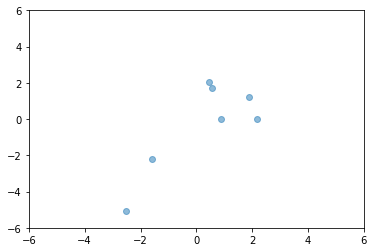

In [331]:
plt.scatter(y_pred, y_test, alpha=0.5)
plt.ylim([-6, 6])
plt.xlim([-6, 6])
print("MSE: {}".format(mean_squared_error(y_pred, y_test)))

### Decision tree

In [334]:
app_dt_model = tree.DecisionTreeRegressor(max_depth=10)
app_dt_cv_model = GridSearchCV(app_dt_model, {"max_depth": range(5, 50)}, cv=5)
app_dt_model.fit(X_train, y_train)
app_dt_cv_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(max_depth=10),
             param_grid={'max_depth': range(5, 50)})

In [335]:
y_dt_pred = app_dt_model.predict(X_test)
pd.DataFrame(y_dt_pred, y_test)

,0
next_q_lvl_app,
-5.063291,-2.127660
1.208333,0.456621
2.040816,1.882353
1.731602,1.154734
0.000000,2.083375
0.000000,0.000000
-2.181818,-2.127660


In [336]:
y_dt_cv_pred = app_dt_cv_model.predict(X_test)
pd.DataFrame(y_dt_cv_pred, y_test)

,0
next_q_lvl_app,
-5.063291,-2.127660
1.208333,1.523448
2.040816,1.523448
1.731602,1.523448
0.000000,1.523448
0.000000,0.114484
-2.181818,-2.127660


MSE: 1.6235944134846978


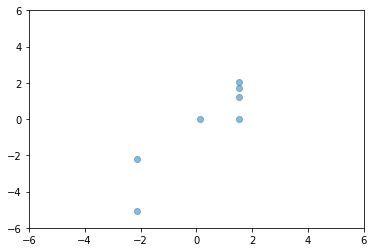

In [337]:
plt.scatter(y_dt_cv_pred, y_test, alpha=0.5)
plt.ylim([-6, 6])
plt.xlim([-6, 6])
print("MSE: {}".format(mean_squared_error(y_dt_cv_pred, y_test)))

### Combine decision tree and regression

MSE: 1.734447039813029


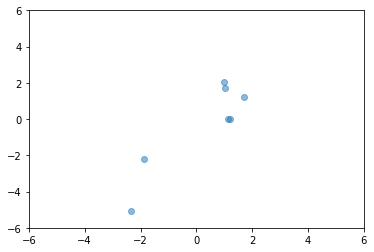

In [338]:
y_comb_pred = (y_pred + y_dt_cv_pred) / 2
plt.scatter(y_comb_pred, y_test, alpha=0.5)
plt.ylim([-6, 6])
plt.xlim([-6, 6])
print("MSE: {}".format(mean_squared_error(y_comb_pred, y_test)))

## Export model

In [339]:
pkl_reg = "E:/Projects/real-estate-analysis/models/lasso_reg_app.pkl"
pkl_dt = "E:/Projects/real-estate-analysis/models/decision_tree_app.pkl"

with open(pkl_reg, "wb") as file:
    pickle.dump(app_model, file)
    
with open(pkl_dt, "wb") as file:
    pickle.dump(app_dt_cv_model, file)